### GARCH and DCC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

#### univariate GARCH

$$r_t = \mu_t + a_t$$
$$a_t = \sqrt{h_t}z_t$$
$$h_t = \alpha_0 + \alpha_1 a_{t-1}^2 + ... + \alpha_q a_{t-q}^2 + \beta_1h_{t-1} + ... + \beta_ph_{t-p}$$

$a_t$ - mean-corrected time series at time t

$h_t$ - conditional variance or square of volatility at time t, conditioned on history

$z_t$ - sequence of iid standardised random variables (E=0, Var=1)

$\alpha, \beta$ - parameters of model

$p, q$ - order of GARCH model

In [77]:
# simulate GARCH(1,1)
n = 1000

alpha_0 = 0.1
alpha_1 = 0.3
beta_1 = 0.5

a = [np.random.normal(0,1)]
h = [1.]

for i in range(n):
    new_h = alpha_0 + alpha_1*a[-1]**2 + beta_1*h[-1]
    new_a = np.random.normal(0,1) * np.sqrt(new_h)
    h.append(new_h)
    a.append(new_a)

Text(0.5, 1.0, 'Simulated GARCH(1,1) data')

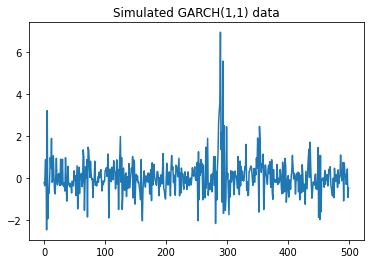

In [78]:
plt.plot(a[:500])
plt.title('Simulated GARCH(1,1) data')

Text(0.5, 1.0, 'Simulated GARCH(1,1) volatility')

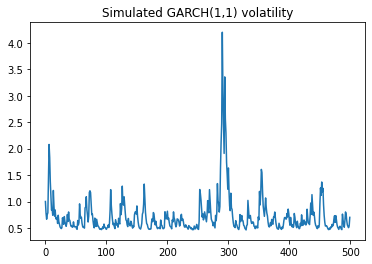

In [79]:
plt.plot(np.sqrt(h[:500]))
plt.title('Simulated GARCH(1,1) volatility')

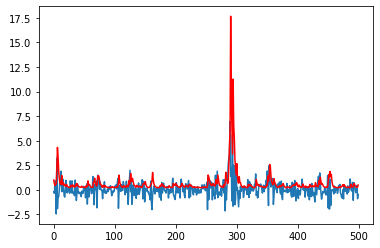

In [80]:
# overlay two plots
plt.plot(a[:500])
plt.plot(h[:500], 'r')

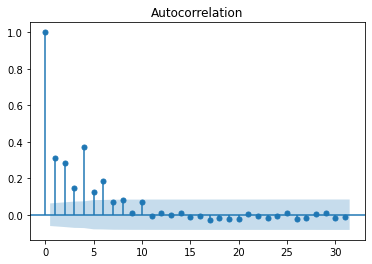

In [81]:
# PACF plot (square a)
_=plot_acf(np.array(a)**2)

In [82]:
# fit model parameters
from arch import arch_model
test_num = 100
train, test = a[:-test_num], a[-test_num:]

In [83]:
model = arch_model(train, p=1, q=1)

In [84]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6077051762261.77
Iteration:      2,   Func. Count:     15,   Neg. LLF: 485686604.62357426
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1075.3135792378216
Iteration:      4,   Func. Count:     28,   Neg. LLF: 963.4286987433968
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1009.3835182410251
Iteration:      6,   Func. Count:     41,   Neg. LLF: 925.6137096140566
Iteration:      7,   Func. Count:     46,   Neg. LLF: 925.5312060965966
Iteration:      8,   Func. Count:     51,   Neg. LLF: 925.4561142723094
Iteration:      9,   Func. Count:     56,   Neg. LLF: 925.4470092677551
Iteration:     10,   Func. Count:     61,   Neg. LLF: 925.4460862086528
Iteration:     11,   Func. Count:     66,   Neg. LLF: 925.4460734762723
Iteration:     12,   Func. Count:     70,   Neg. LLF: 925.446073476299
Optimization terminated successfully    (Exit mode 0)
            Current function value: 925.4460734762723
            Iterations: 12


In [85]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -925.446
Distribution:                  Normal   AIC:                           1858.89
Method:            Maximum Likelihood   BIC:                           1878.11
                                        No. Observations:                  901
Date:                Tue, Feb 09 2021   Df Residuals:                      897
Time:                        11:30:20   Df Model:                            4
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.0186e-03  1.862e-02      0.431      0.667 [-2.848e-02,4.452e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0998  1.778e-02      5.617  1.944e-08 [6.500e-02,  0.135]
alpha[1]       0.4667  6.489e-02      7.193  6.320e-13   [  0.340,  0.594]
beta[1]        0.3993  5.826e-02      6.853  7.240e-12   [  0.285,  0.513]
==========================================================================

Covariance estimator: robust
"""

In [95]:
# prediction
pred = model_fit.forecast(horizon=test_num)

In [96]:
pred_v = pred.variance.values[-1,:]

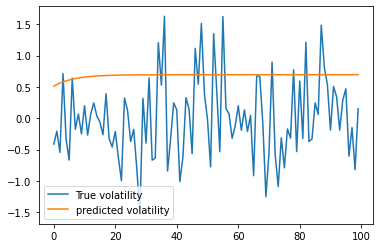

In [98]:
plt.plot(a[-test_num:])
plt.plot(pred_v)
plt.legend(['True volatility', 'predicted volatility'])

In [93]:
# rolling forecast
rolling_pred = []
for i in range(test_num):
    train = a[:-(test_num-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_pred.append(pred.variance.values[-1,:][0])

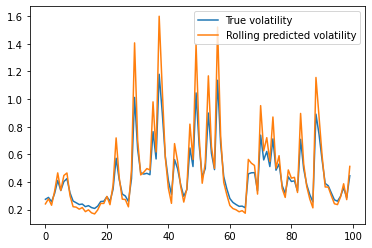

In [94]:
plt.plot(h[-test_num:])
plt.plot(rolling_pred)
plt.legend(['True volatility', 'Rolling predicted volatility'])

#### multivariate GARCH

$$r_t = \mu_t + a_t$$
$$a_t = \sqrt{H_t}z_t$$

$a_t$ - n x 1 vector of mean corrected n time series at time t (E=0, Cov=Ht)

$H_t$ - n x n matrix of conditional variances of $a_t$ at time t

DCC GARCH belongs to models of conditional variances and correlations (instead of modelling the conditional covariance matrix). The conditional covariance matrix can be decomposed into conditional standard deviations $D_t$ and a correlation matrix $R_t$:

$$H_t = D_t R_t D_t$$

where $D_t = diag(\sqrt{h_{1t}},...,\sqrt{h_{nt}})$. $R_t$ can either be constant or time-varying (the DCC output we want).

$R_t$ is the conditional correlation matrix of the standardised errors $\epsilon_t$:

$$\epsilon_t = D^{-1}a_t \sim N(0, R_t)$$

$R_t$ has to be positive definitive (since $H_t$ is a covariance matrix). All elements in $R_t$ has to be equal or less than 1. To ensure these, $R_t$ is decomposed to:

$$R_t = Q_t^{*-1} Q_t Q_t^{*-1} $$

$$Q_t = (1-a-b)\bar{Q} + a \epsilon_{t-1} \epsilon{t-1}^T + b Q_{t-1}$$

where $\bar{Q}=Cov[\epsilon_t\epsilon_t^T] = E[\epsilon_t\epsilon_t^T]$ is the unconditional covariance matrix of the standardised errors, and can be estimated as:

$$\bar{Q} = \frac 1 T \sum_{t=1}^T \epsilon_t\epsilon_t^T$$

and $Q^*_t$ is a diagonal matrix with square root of the diagonal elements of $Q_t$ at the diagonal.

To guarantee positive definite, 

$a \ge0 , b \ge0, a+b \ge 1$

#### estimate DCC-GARCH

2 stage estimation

1. parameter $Phi$ of univariate GARCH model estimated for each time series ($\alpha_{0i}, \alpha_{1i}, \alpha_{qi}... \beta_{1i}, \beta_{pi}$). Likelihood used in 1st stage results in replacing R with identity matrix.

2. parameter $\Psi$ (a, b) estimated using the correctly specified log likelihood, given parameter $\Phi$

#### DCC-GARCH code and docs
Using [DCC-GARCH](https://github.com/Topaceminem/DCC-GARCH), which coded the equations in the [this thesis](https://www.nr.no/directdownload/5034/Orskaug_-_Multivariate_DCC-GARCH_Model_-_With_Various_Error.pdf).

In [146]:
# DCC generate Qs
import numpy as np

def Q_average(tr):
    # Qbar, equation 29+1 p17
    # return average of outer product of [eT,...e0]
    # et = [r(1t)/s(1t),...r(nt)/s(nt)]
    T = tr.shape[1]
    n = tr.shape[0]
    sum = np.zeros([n,n])
    for i in range(T):
        sum += np.outer(tr[:,i],tr[:,i])
    return sum/T

def Q_gen(tr,ab):
    # generate [QT,...Q0], update Qt equation 29 p17
    Q_int = Q_average(tr)
    Q_list = [Q_int]
    T = tr.shape[1] - 1
    a = ab[0]
    b = ab[1]
    for i in range(T):
        et_1 = tr[:,T-i]
        Qt_1 = Q_list[0]
        Qt = (1.0-a-b)*Q_int + a*np.outer(et_1,et_1) + b*Qt_1
        Q_list = [Qt] + Q_list
    return Q_list

def R_gen(tr,ab):
    # generate Rt, equation 28 p17
    Q = Q_gen(tr,ab)
    # output [RT,...R0]
    R_list = []
    n = Q[0].shape[0]
    for i in Q: # Rt = Qt^*-1 Qt Qt^*-1
        temp = 1.0/np.sqrt(np.abs(i)) # inverse of diagonal matrix is 1/sqrt(q_iit)
        temp = temp * np.eye(n)  # diagonal
        R = np.dot(np.dot(temp,i),temp)
        R_list = R_list + [R]
    return R_list

def dcc_loss(tr, ab):
    # loglik for dcc, equation 34 p20
    R = R_gen(tr,ab)

    def dcc_loss_helper(tr=tr,R=R):
        loss = 0.0
        for i in range(len(R)):
            Ri = R[i]
            Ri_ = np.linalg.inv(Ri)
            ei = tr[:,i]
            loss += np.log(np.linalg.det(Ri)) + np.dot(np.dot(ei,Ri_),ei)
        # print('training loss %f' % loss)
        return loss

    return dcc_loss_helper()


def dcc_loss_gen():
    def loss1(tr):
        def loss(ab):
            return dcc_loss(tr, ab)
        return loss
    return loss1

In [147]:
# DCC class for fitting
import numpy as np
from scipy.optimize import minimize
# from DCC_GARCH.DCC.DCC_loss import Q_gen, Q_average

class DCC():

    def __init__(self, max_itr=2, early_stopping=True):
        self.max_itr = max_itr
        self.early_stopping = early_stopping
        self.ab = np.array([0.5, 0.5])
        self.method =  'SLSQP'
        def ub(x): # upper bound (a+b<=1)
            return 1. - x[0] - x[1]
        def lb1(x): # lower bound a>=0
            return x[0]
        def lb2(x): # lower bound b>=0
            return x[1]
        self.constraints = [{'type':'ineq', 'fun':ub},{'type':'ineq', 'fun':lb1},{'type':'ineq', 'fun':lb2}]

    def set_ab(self,ab): # ndarray
        self.ab = ab

    def get_ab(self):
        return self.ab

    def set_method(self,method):
        self.method = method

    def set_loss(self, loss_func):
        #"loss function L is a meta-function, s.t. L(r) = f(theta)."
        self.loss_func = loss_func

    def get_loss_func(self):
        if self.loss_func is None:
            raise Exception("No Loss Function Found!")
        else:
            return self.loss_func

    def set_max_itr(self, max_itr):
        self.max_itr = max_itr

    def get_max_itr(self):
        return self.max_itr

    def fit(self, train_data):
        #train_data: numpy.array([[e1_T,...e1_0],\
        #                         [e2_T,...e2_0],\
        #                         ...,
        #                         [en_T,...en_0]])

        tr = train_data

        # Optimize using scipy and save theta
        tr_losses = []
        j = 0
        count = 0
        while j < self.get_max_itr():
            j += 1
            ab0 = np.array(self.get_ab())
            res = minimize(self.get_loss_func()(tr), ab0, method=self.method,
                           options={'disp': True},constraints=self.constraints)
            ab = res.x
            self.set_ab(ab)

            tr_loss = self.get_loss_func()(tr)(ab)
            tr_losses.append(tr_loss)
            print("Iteration: %d. Training loss: %.3E." % (j, tr_loss))

            # Early stopping
            if self.early_stopping is True:
                if j > 10:
                    if abs(tr_losses[-1] - tr_losses[-2]) / tr_losses[-2] < 0.0001:
                        count += 1
                        if count >= 2:
                            print("Early Stopping...")
                            return tr_losses

        return tr_losses


    def Q(self,y):
        Q = Q_gen(y,self.ab)
        return Q

    def Q_bar(self,y):
        return Q_average(y)

In [195]:
# GARCH(1,1) update and loss function
# from lib import *
import numpy as np

def garch_process(r, theta, p=1, q=1):
    w, alpha, gamma, beta = theta[0], theta[1:1 + p], theta[1 + p:1 + p + p], theta[1 + p + p:]
    if len(gamma) is not q:
        raise Exception('Parameter Length Incorrect!')
    r = np.array(r)
    T = len(r) - 1

    def garch_update(s, r, t, alpha, beta, gamma, p=p, q=q, T=T):
        "s = [st-1,...s0], r = [rT,...,r0], t is time" \
        "alpha, beta and gamma are from above" \
        "returns new_s = [st,...,s0]"
        r_temp = r[T - t + 1:T - t + 1 + q]  # [rt-1,...,rt-q] = a
        s_temp = s[0:p]  # [st-1,...st-p] = sqrt(h) in equation 1-3 p3

        var = np.array(s_temp) ** 2
        r_squared = np.array(r_temp) ** 2
        gjr = r_squared*(np.array(r_temp)<0)
        st = np.sqrt(np.abs(np.dot(np.array(beta), var) 
                    + np.dot(np.array(alpha), r_squared)
                    + np.dot(np.array(gamma), gjr) + w))

        new_s = [st] + s

        return new_s #[sT,...,s0] = new h

    #"Initialize values of s and m as data variance and mean"
    s_int = np.std(r)
    L = max(p, q)
    s = [s_int for i in range(0, L)]

    for t in range(L, T + 1):
        s = garch_update(s, r, t, alpha, beta, gamma)

    return s


def garch_loss(r, theta, p, q):
    s = garch_process(r, theta, p, q)

    def garch_loss_helper(r=r, s=s):
        s = np.array(s)
        loss = 0.0
        for i in range(len(r)):
            tmp = np.log(s[i] ** 2) + (r[i]/s[i])**2
            if np.isinf(tmp):
                loss += 0.
            else:
                loss += np.log(s[i] ** 2) + (r[i]/s[i])**2 # equation 16 in p8

#         print('training loss %f' % loss)
        return loss

    return garch_loss_helper()


def garch_loss_gen(p=1, q=1):
    def loss1(r):
        def loss(theta):
            return garch_loss(r, theta, p, q)
        return loss
    return loss1

In [196]:
# GARCH(1,1) class for fitting
import numpy as np
from scipy.optimize import minimize
# from DCC_GARCH.GARCH.GARCH_loss import garch_process


class GARCH():

    def __init__(self, p=1, q=1, max_itr=3, early_stopping=True):
        # p the lag of r_t, q the lag of s_t
        self.p = p
        self.q = q
        theta0 = [0.005] + [0.1 for i in range(p)] + [0.1 for i in range(p)] + [0.85 for i in range(q)]
        self.theta = np.array(theta0)
        self.max_itr = max_itr
        self.early_stopping = early_stopping
        def ub(x):
            return 1. - x[1] - 0.5*x[2] - x[3]
        def lb1(x):
            return x[1] + x[2]
        def lb2(x):
            return x[0]
        def lb3(x):
            return x[1]
        def lb4(x):
            return x[3]
        self.constraints = [{'type':'ineq', 'fun':ub},{'type':'ineq', 'fun':lb1},
                            {'type':'ineq', 'fun':lb2},{'type':'ineq', 'fun':lb3},
                            {'type':'ineq', 'fun':lb4}]
        self.method = 'COBYLA'

    def set_theta(self, theta):
        self.theta = np.array(theta)

    def get_theta(self):
        return self.theta

    def get_p(self):
        return self.p

    def get_q(self):
        return self.q

    def set_loss(self, loss_func):
        "loss function L is a meta-function, s.t. L(r) = f(theta)."
        self.loss_func = loss_func

    def get_loss_func(self):
        if self.loss_func is None:
            raise Exception("No Loss Function Found!")
        else:
            return self.loss_func

    def set_max_itr(self, max_itr):
        self.max_itr = max_itr

    def get_max_itr(self):
        return self.max_itr

    def set_method(self, method):
        self.method = method

    def get_method(self):
        return self.method

    def fit(self, train_data):  # train_data: [rT,...r0]
        tr = train_data

        # Optimize using scipy and save theta
        tr_losses = []
        j = 0
        count = 0
        while j < self.get_max_itr():
            j += 1
            theta0 = self.get_theta()
            res = minimize(self.get_loss_func()(tr), theta0, method=self.method,
                           options={'disp': True}, constraints=self.constraints)
            theta = res.x
            self.set_theta(theta)

            tr_loss = self.get_loss_func()(tr)(theta)
            tr_losses.append(tr_loss)
            print("Iteration: %d. Training loss: %.3E." % (j, tr_loss))

            # Early stopping
            if self.early_stopping is True:
                if j > 10:
                    if abs(tr_losses[-1] - tr_losses[-2]) / tr_losses[-2] < 0.0001:
                        count += 1
                        if count >= 2:
                            print("Early Stopping...")
                            return tr_losses
        return tr_losses

    def sigma(self, y):  # test data: [rT,...r0]
        s = garch_process(y, self.theta, self.p, self.q)
        return np.array(s)

In [197]:
import pandas as pd
sp = pd.read_csv('../DCC-GARCH/examples/data/^GSPC.csv').set_index('Date')
jpm = pd.read_csv('../DCC-GARCH/examples/data/JPM.csv').set_index('Date')

In [198]:
sp['Adj Close'].shape

(2515,)

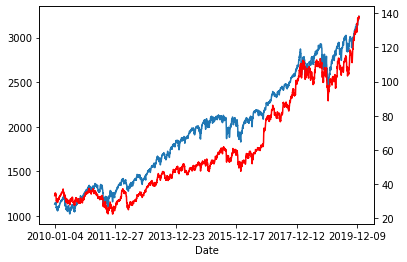

In [199]:
fig, ax1 = plt.subplots()
y1 = sp['Adj Close'].plot(ax=ax1)
ax2 = ax1.twinx()
y2 = jpm['Adj Close'].plot(c='r', ax=ax2)

In [200]:
sp_return = np.log(sp['Adj Close']).diff().dropna() # log return of S&P500 index
jpm_return = np.log(jpm['Adj Close']).diff().dropna() # log return of JP Morgan Chase & Co.

In [201]:
sp_return = sp_return.iloc[::-1] # the latest data should come first
jpm_return = jpm_return.iloc[::-1] # the latest data should come first

<AxesSubplot:label='61f4fdcf-15cb-4948-9eb0-dc9806c04a21', xlabel='Date'>

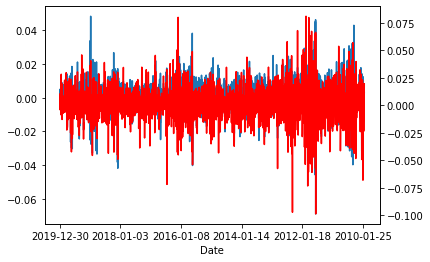

In [202]:
fig, ax1 = plt.subplots()
sp_return.plot(ax=ax1)
ax2 = ax1.twinx()
jpm_return.plot(c='r', ax=ax2)

In [206]:
# step 1. solve GARCH(1,1) for time series
sp_model = GARCH(1,1)
sp_model.set_loss(garch_loss_gen(1, 1))
sp_model.set_max_itr(1)

In [207]:
sp_model.fit(sp_return)

Iteration: 1. Training loss: -2.161E+04.


[-21613.854066304382]

In [208]:
sp_model.get_theta()

array([3.36667947e-29, 3.41394161e-02, 6.25933353e-02, 9.34563916e-01])

In [209]:
jpm_model = GARCH(1,1)
jpm_model.set_loss(garch_loss_gen(1, 1))
jpm_model.set_max_itr(1)

In [210]:
jpm_model.fit(jpm_return)

Iteration: 1. Training loss: -1.395E+04.


[-13946.160428990781]

In [211]:
jpm_model.get_theta()

array([1.00000000e-04, 1.33273439e-02, 3.10362112e-02, 9.71154551e-01])

In [215]:
# getting garch using fitted parameters
sp_sigma = sp_model.sigma(sp_return)
sp_epsilon = sp_return / sp_sigma

jpm_sigma = jpm_model.sigma(jpm_return)
jpm_epsilon = jpm_return / jpm_sigma

In [216]:
epsilon = np.array([sp_epsilon,jpm_epsilon])

In [218]:
epsilon.shape

(2, 2514)

In [219]:
# step 2 get dcc
dcc_model = DCC()

In [220]:
dcc_model.set_loss(dcc_loss_gen())

In [221]:
dcc_model.fit(epsilon)

<ipython-input-146-af2e3b5b62fe>:25: RuntimeWarning: overflow encountered in multiply
  Qt = (1.0-a-b)*Q_int + a*np.outer(et_1,et_1) + b*Qt_1
/Users/syzhang/opt/anaconda3/envs/img/lib/python3.8/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
<ipython-input-146-af2e3b5b62fe>:52: RuntimeWarning: invalid value encountered in log
  loss += np.log(np.linalg.det(Ri)) + np.dot(np.dot(ei,Ri_),ei)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2832.458546405614
            Iterations: 13
            Function evaluations: 46
            Gradient evaluations: 13
Iteration: 1. Training loss: 2.832E+03.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2832.458546243686
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration: 2. Training loss: 2.832E+03.


[2832.458546405614, 2832.458546243686]

In [222]:
dcc_model.get_ab()

array([0.02843232, 0.95110395])

In [223]:
# get DCC
ab = dcc_model.get_ab()
tr = epsilon
R_ls = R_gen(tr,ab)

In [227]:
R = np.array(R_ls)

In [234]:
R.shape

(2514, 2, 2)

In [235]:
R[0,:,:]

array([[1.        , 0.66269602],
       [0.66269602, 1.        ]])

In [238]:
R[0,np.triu(np.ones((K,K)),1)>0]

array([0.66269602])

In [246]:
# flatten Rt
K = R.shape[1]
Rt_triu = R[:,np.triu(np.ones((K,K)),1)>0].T
dcc_out = Rt_triu[0]

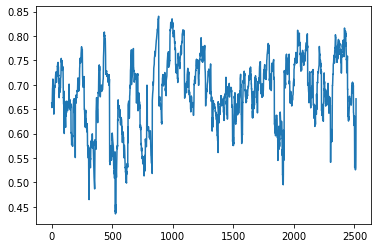

In [247]:
plt.plot(dcc_out)

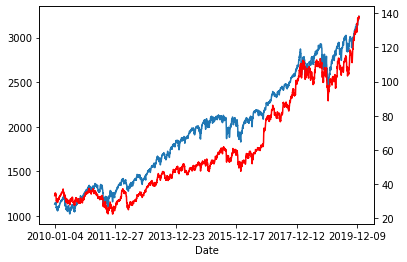

In [199]:
fig, ax1 = plt.subplots()
y1 = sp['Adj Close'].plot(ax=ax1)
ax2 = ax1.twinx()
y2 = jpm['Adj Close'].plot(c='r', ax=ax2)

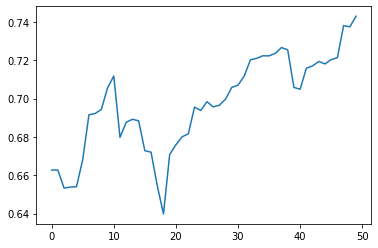

In [248]:
plt.plot(dcc_out[:50])

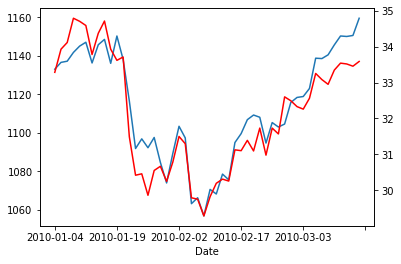

In [249]:
fig, ax1 = plt.subplots()
y1 = sp['Adj Close'].iloc[:50].plot(ax=ax1)
ax2 = ax1.twinx()
y2 = jpm['Adj Close'].iloc[:50].plot(c='r', ax=ax2)